In [105]:
import numpy as np
from numba import jit
from numba.typed import List
import osmnx as ox
from keplergl import KeplerGl
import pandas as pd
import geopandas as gpd
import time

In [2]:
# Download a street graph of London city centre

north = 51.5219026
south = 51.4925076
east = -0.0670541
west = -0.1678206

G = ox.graph_from_bbox(north,south, east, west, retain_all=True, simplify = True, network_type='drive') 

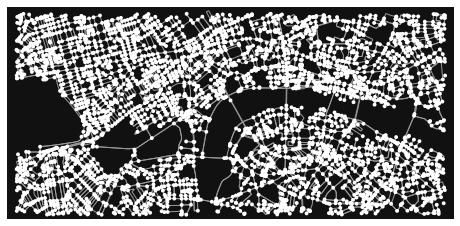

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
ox.plot_graph(G)

In [5]:
# Extreact endpoints for every street

data = list()
xu = List()
yu = List()
xv = List()
yv = List()
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    xv.append(G.nodes[vv]['x'])
    xu.append(G.nodes[uu]['x'])
    yu.append(G.nodes[uu]['y'])
    yv.append(G.nodes[vv]['y'])
    data.append(ddata)  
    
# extreact geometries for every street

geoms = List()
for i in range(0, len(data)):
    if 'geometry' in data[i].keys():
        geoms.append(List((List(data[i]['geometry'].coords.xy[0]),List(data[i]['geometry'].coords.xy[1]))))
    else:
        geoms.append(List((List((xv[i],xu[i])),List((yv[i], yu[i])))))

In [131]:
@jit
def dist(x1, x2, y1, y2): 
  # Calculate distance
    numerator = np.abs(x2*y1 - y2*x1)
    denominator = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    frac = numerator/denominator
    return frac

@jit
def get_nearest_street(x, y, xv, xu, yv, yu, geoms): 
# Get the index of the nearest street
# xv, xu, yv, yu - coordinates of streets endpoints

    res = 100
    nearest_num = np.nan
    acute = False
    d = 0.007
    
    # cycle over all the streets
    for i in range(0, len(xv)):
        # transform the coordinates and calculate distance
        x1 = xv[i] - x
        x2 = xu[i] - x
        y1 = yv[i] - y
        y2 = yu[i] - y
        a = [x2-x1,y2-y1]
        # continue if the street is too far away
        if (np.abs(x1) > d) and (np.abs(x2) > d) and (np.abs(y1) > d) and (np.abs(y2) > d):
            continue        
            
        # Check if the street and the datapoint forms an acute triangle
        scalar_product = np.sign(a[0]*x2+a[1]*y2)*np.sign(a[0]*x1+a[1]*y1)
        if scalar_product < 0:
          
            # cycle over all the subsegments
            for c in range(0, len(geoms[i][0])-1):
                x1 = geoms[i][0][c] - x
                x2 = geoms[i][0][c+1] - x
                y1 = geoms[i][1][c] - y
                y2 = geoms[i][1][c+1] - y
                
                # Check if the subsegment and the datapoint forms an acute triangle
                scalar_product = np.sign(a[0]*x2+a[1]*y2)*np.sign(a[0]*x1+a[1]*y1)
                if scalar_product < 0:
                  
                    distance = dist(x1, x2, y1, y2)
            
                    # remember the index of the nearest street
                    if distance <= res:
                        res = distance
                        nearest_num = i
    return nearest_num

In [127]:
# Create a ramdom set of 1K points
points_x = south + np.random.rand(1000)*(north - south)
points_y = east + np.random.rand(1000)*(west - east)

In [122]:
KeplerGl(data = {'data': pd.DataFrame({'lat': points_x, 'lon': points_y})})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data':           lat       lon
0   51.505416 -0.087499
1   51.498946 -0.074587
2   51.502113 -…

In [130]:
# I ran this cell this cell without using numba just to demonstrate efficiensy gain

t = time.time()
closest_id = list()
for point in range(len(points_x)):
    
    point_x = points_y[point]
    point_y = points_x[point]

    ind = get_nearest_street(point_x, point_y, xv, xu, yv, yu, geoms)
    closest_id.append(int(ind))
closest_id = np.array(closest_id)
t = time.time() - t
print(t//3600, 'hours,', (t%3600)//60, 'miunutes', t%60,'seconds')

0.0 hours, 4.0 miunutes 27.08525252342224 seconds


In [132]:
# This cell has been ran with numba
# Process time dropped from 4.5 minutes to only 3.4 seconds!

t = time.time()
closest_id = list()
for point in range(len(points_x)):
    
    point_x = points_y[point]
    point_y = points_x[point]
    
    ind = get_nearest_street(point_x, point_y, xv, xu, yv, yu, geoms)
    closest_id.append(int(ind))
closest_id = np.array(closest_id)
t = time.time() - t
print(t//3600, 'hours,', (t%3600)//60, 'miunutes', t%60,'seconds')

0.0 hours, 0.0 miunutes 3.3639187812805176 seconds


In [120]:
# this cell is to visually inspect which points are associated to which streets 

n = 214
KeplerGl(data = {
    'street': gpd.GeoDataFrame(geometry = [data[n]['geometry']]),
    'points': pd.DataFrame({'lat': points_x[closest_id == n], 
                            'lon': points_y[closest_id == n]})
})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'street':                                             geometry
0  LINESTRING (-0.11409150000000…